
# <span style="color:rgb(213,80,0)">Basic Diffusion Tensor MRI processing and representation</span>

This demo illustrates the basic use of the tensor module, which provides tools for the computation of standard DT\-MRI representations.


In [1]:
addpath('..');
setup__DMRIMatlab_toolbox('useparallel',false); % Will be ingnored if you don't have a licensed copy of the parallel toolbox
clear;
close('all');


















You're running version 1.0 of the toolbox under octave 10.20
Using graphics toolkit: qt




## Load data

First, load adequate diffusion MRI data (either single\-shell or multi\-shell). Note all functions starting with "atti2..." require an attenuation signal as input. This attenuation signal is not the Diffusion Weighted Image (DWI) itself, but the result of normalizing each actual diffusion\-weigthed channel (those corresponding to a b\-value greater than 0) by the unweighted T2\-baseline image (the one with b=0). In case you have loaded a DWI image, use **dwi2atti.m** (in the "io" folder) to make the conversion.


For this demo, we will load a test data set that comprises one such attenuation signal, together with a background\-removal mask, the gradients table, and the b\-values for each gradient direction:


In [2]:
tic;
load test_data.mat;
T = toc; % This is always a large piece of data
fprintf(1,'It took %f seconds to load data\n',T);
whos -file test_data.mat; % Check the variables loaded, their kinds, and their sizes





It took 1.312281 seconds to load data

Variables in the file test_data.mat:

variables in scope: test_data.mat

  Attr   Name        Size                     Bytes  Class
  ====   ====        ====                     =====  ===== 
         atti      101x110x17x256         193402880  single
         bi        256x1                       2048  double
         gi        256x3                       6144  double
         mask      101x110x17                188870  logical

Total is 48540614 elements using 193599942 bytes




It is important to remind that the DT\-MRI formalism is suitable only for b\-values below 2,000 s/mm^2. In case the whole data set were used, many artifacts in important ROIs might appear. Hence, we will keep just the innermost shells with b<=2,000 s/mm^2.


In [3]:
pp   = (bi<=2000);
atti = atti(:,:,:,pp);
gi   = gi(pp,:);
bi   = bi(pp);

## Estimate the diffusion tensor

The toolbox implements a number of commonly used estimation methods. The simplest (and the fastest) is ordinary, non\-weighted least squares. This may be invoked by disabling the weighted and non\-linear options of the estimation function, **atti2dti.m**:


In [4]:
tic;
tensor = atti2dti( atti, gi, bi, 'mask', mask, ...
    'wls', false, 'nonlinear', false );
T = toc;
fprintf(1,'It took %f seconds to estimate the tensor\n',T);
% Note this function is multi-threaded. You can suppress this behavior
% by fixing maxthreads=1:
tic;
atti2dti( atti, gi, bi, 'mask', mask, ...
    'wls', false, 'nonlinear', false, 'maxthreads', 1 );
T = toc;
fprintf(1,'It took %f seconds to estimate the tensor\n',T);
size(tensor),






It took 0.239697 seconds to estimate the tensor







It took 0.127417 seconds to estimate the tensor

ans =

   101   110    17     6




Note the tensor is represented by its 6 unique (different) components Dxx, Dxy, Dyz, Dyy, Dyz, Dzz, stored in the array's last dimension. This default behavior can be overridden with the 'unroll' option:


In [5]:
[tensor,S0n] = atti2dti( atti, gi, bi, 'mask', mask, ...
    'wls', false, 'nonlinear', false, 'unroll', true );
size(tensor),




ans =

   101   110    17     3     3




Note that an additional output S0n is also returned, standing for the (normalized) estimated baseline.


Ordinary least squares are known to be sub\-optimal. It is strongly recommended to use the weighted (slower, but more accurate) re\-weighted version instead:


In [6]:
tic;
atti2dti( atti, gi, bi, 'mask', mask, ...
    'wls', true, 'nonlinear', false );
T = toc;
fprintf(1,'It took %f seconds to estimate the tensor\n',T);






It took 0.394996 seconds to estimate the tensor



Even when weighted least squares are used, there is no warranty that the estimated tensor fulfills the theoretical requirements of a diffusion tensor, i.e. being positive semi\-definite. In certain voxels, the diffusion tensor might have negative eigenvalues, which in turn might result in out\-of\-bounds values suchs as Fractional Anisotropies greater than 1. To account for this, a third, more sophisticated but yet slower method, is implemented: the square root of the tensor (which is also symmetric) is non\-linearly fitted to the attenuation signal, which results in non\-negative eigenvalues for all voxels:


In [7]:
tic;
tensor = atti2dti( atti, gi, bi, 'mask', mask, ...
    'wls', true, 'nonlinear', true );
T = toc;
fprintf(1,'It took %f seconds to estimate the tensor\n',T);
% The differences in threaded execution times may be more noticeable
% for slower methods:
tic;
atti2dti( atti, gi, bi, 'mask', mask, ...
    'wls', true, 'nonlinear', true, 'maxthreads', 1 );
T = toc;
fprintf(1,'It took %f seconds to estimate the tensor\n',T);






It took 1.232587 seconds to estimate the tensor







It took 6.343486 seconds to estimate the tensor



**NOTE:** **atti2dti.m** is a wrapper for **atti2dti\_.cpp**, which is a C++/mex implementation directly invoking Lapack's routines. In Linux, POSIX threads are used to estimate different voxels in parallel. In Windows and MAC OS, Lapack is allowed to use its own threads (which seems to be less efficient).

## Alternatively estimate the diffusion tensor

The diffusion tensor may be otherwise estimated, without resorting to **atti2dti.m**, by exploiting the equivalence of the spaces generated by Spherical Harmonics (SH) and Higher Order Tensors (HOT). In particular, the 6 free coefficients of the diffusion tensor may be directly obtained from the 6 coefficients of the SH expansion of the Apparent Diffusion Coefficient (ADC) up to order L=2. First, use  **atti2shadc.m** to fit the ADC to the SH basis:


In [8]:
sh = atti2shadc( atti, gi, bi, 'L', 2, 'mask', mask, 'lambda', 0.001 );
size(sh),



ans =

   101   110    17     6




The SH coefficients are fitted with Least Squares regularized with a Laplace\-Beltrami  penalty. The computation of the diffusion tensor reduces to a change of basis, which is implemented in **shadc2dti.m**:


In [9]:
tensor2 = shadc2dti( sh, 'mask', mask, 'unroll', false );
size(tensor2),



ans =

   101   110    17     6




The **shadc2dti.m**  is a particular case of the more general funcion  **sh2hot.m** (which is, indeed, a wrapper for the mex function **sh2hot\_.cpp**), so the previous call should be equivalent to:


In [10]:
tensor3 = sh2hot( sh, 'mask', mask );
size(tensor3),



ans =

   101   110    17     6




Let's check for a random voxel:


In [11]:
1000*squeeze( tensor(43,67,9,:) )', % As estimated with atti2dti, non-negative/non-linear
1000*squeeze( tensor2(43,67,9,:) )', % As estimated with atti2shadc + shadc2dti
1000*squeeze( tensor3(43,67,9,:) )', % As estimated with atti2shadc + sh2hot


ans =

   1.083423  -0.278236   0.031576   0.526535  -0.128691   0.577924


ans =

   1.189746  -0.275781   0.027285   0.526003  -0.111272   0.571996


ans =

   1.189746  -0.275781   0.027285   0.526003  -0.111272   0.571996




This way of estimating the tensor, though might seem awkward, can be useful in an scenario where the SH coefficients up to a given order L (let's say L=8) have been already computed and one desires to find the closest tensor representation. In this case, it suffices to retain the first 6 SH coefficients (because SH form an orthonormal basis):


In [12]:
% High frequency representation of the ADC, up to SH order 8:
sh = atti2shadc( atti, gi, bi, 'L', 8, 'mask', mask, 'lambda', 0.001 );
size(sh),
% Closest diffusion tensor representation to the high frequency one:
tensor4 = sh2hot( sh(:,:,:,1:6), 'mask', mask );
size(tensor4),
1000*squeeze( tensor4(43,67,9,:) )',




ans =

   101   110    17    45




ans =

   101   110    17     6


ans =

   1.189782  -0.278132   0.029164   0.520742  -0.109805   0.573906



## Compute the spectrum of the diffusion tensor

The eigenvalues and eigenvectors of the diffusion tensor are referred to as its spectrum. The function used to compute them is **dti2spectrum.m** (a wrapper for the C++/mex, mult\-threaded **dti2spectrum\_cpp**). From now on, we will use the variable "tensor", obtained from the non\-linear, non\-negative method. This ensures no negative eigenvalues will appear:


In [13]:
[u1,u2,u3,l1,l2,l3] = dti2spectrum( tensor, 'mask', mask );


Variables u1, u2, u3 contain the eigenvectors (3x1, unit\-norm vectors) corresponding to the respective eigenvalues l1 >= l2 >= l3:


In [14]:
size(u1), % The fourth dimension contains the 3 components of the eigenvector
size(l1),


ans =

   101   110    17     3


ans =

   101   110    17




Since we have used the non\-linear, non\-negative estimation method for the tensor, no negative eigenvalues should be present:


In [15]:
any(l1(mask)<-eps), % Avoid false negatives due to numerical precision issues in Lapack's eigenvalue computation
any(l2(mask)<-eps), % Avoid false negatives due to numerical precision issues in Lapack's eigenvalue computation
any(l3(mask)<-eps), % Avoid false negatives due to numerical precision issues in Lapack's eigenvalue computation


ans = 0

ans = 0

ans = 0


## Compute and represent scalar maps

DT\-MRI studies are usually based on scalar maps computed from the eigenvalues of the diffusion tensor. We will use the spectrum obtained in the previous section to compute these scalars with **spectrum2scalar.m**. Since no negative eigenvalues are present, no out\-of\-bounds values are expected to appear. Let's start with the most commonly used scalar maps:























    imshow at line 206 column 7
    plotVolBW_demoDTI at line 10 column 1





    imshow at line 206 column 7
    plotVolBW_demoDTI at line 10 column 1




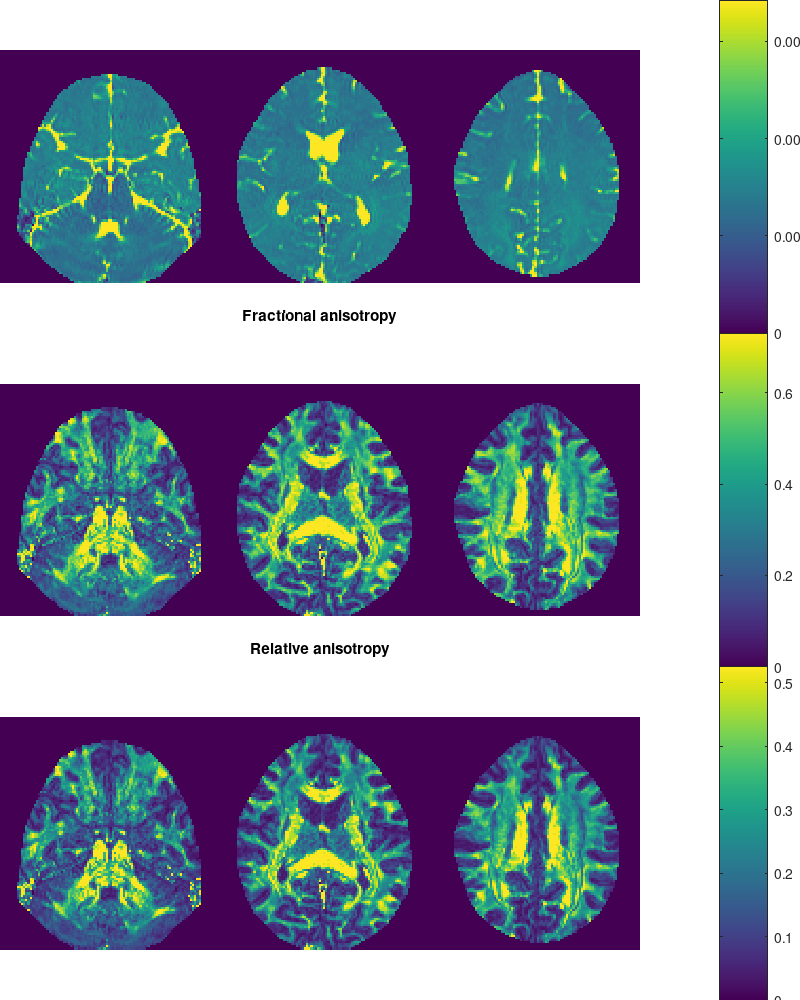

In [16]:
% The mean diffusivity, should be between 0.0 and free-water diffusivity,
% 3.0e-3 mm^2/s:
MD = spectrum2scalar( l1, l2, l3, 'mask', mask, 'scalar', 'md' );
% The fractional anisotropy, in the interval [0,1]:
FA = spectrum2scalar( l1, l2, l3, 'mask', mask, 'scalar', 'fa' );
% The realtive anisotropy, in the interval [0,1]:
RA = spectrum2scalar( l1, l2, l3, 'mask', mask, 'scalar', 'ra' );
% -------------
FS = 24;
close(figure(1));
hf1 = figure(1);
set(hf1,'Name','DT-MRI standard measures','Position',[10,10,800,1000]);
% ---
R=3; C=1;
% ---
r=3; c=1; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
plotVolBW_demoDTI(MD); title('Mean diffusivity','FontSize',FS);
axis('equal');axis('off');axis('tight');
% ---
r=2; c=1; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
plotVolBW_demoDTI(FA); title('Fractional anisotropy','FontSize',FS);
axis('equal');axis('off');axis('tight');
% ---
r=1; c=1; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
plotVolBW_demoDTI(RA); title('Relative anisotropy','FontSize',FS);
axis('equal');axis('off');axis('tight');


An alternative representation is based on Westin's coefficients, a set of values in the range \[0,1\], whose sum is 1, and which represent how close the tensor is to be completely linear, completely planar, or completely spherical:



















    imshow at line 206 column 7
    plotVolBW_demoDTI at line 10 column 1





    imshow at line 206 column 7
    plotVolBW_demoDTI at line 10 column 1





    imshow at line 206 column 7
    plotVolBW_demoDTI at line 10 column 1




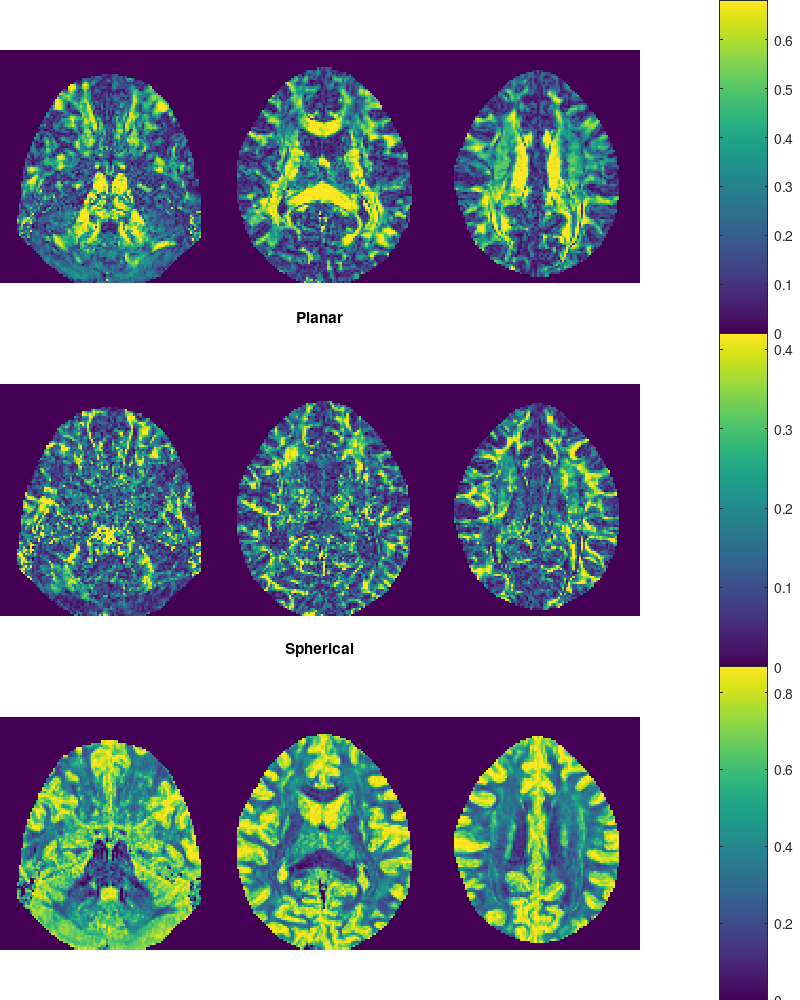

In [17]:
% The mean diffusivity, should be between 0.0 and free-water diffusivity,
% 3.0e-3 mm^2/s:
CL = spectrum2scalar( l1, l2, l3, 'mask', mask, 'scalar', 'cl' );
% The fractional anisotropy, in the interval [0,1]:
CP = spectrum2scalar( l1, l2, l3, 'mask', mask, 'scalar', 'cp' );
% The realtive anisotropy, in the interval [0,1]:
CS = spectrum2scalar( l1, l2, l3, 'mask', mask, 'scalar', 'cs' );
% -------------
FS = 24;
close(figure(2));
hf2 = figure(2);
set(hf2,'Name','Westin''s coefficients','Position',[10,10,800,1000]);
% ---
R=3; C=1;
% ---
r=3; c=1; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
plotVolBW_demoDTI(CL); title('Linear','FontSize',FS);
axis('equal');axis('off');axis('tight');
% ---
r=2; c=1; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
plotVolBW_demoDTI(CP); title('Planar','FontSize',FS);
axis('equal');axis('off');axis('tight');
% ---
r=1; c=1; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
plotVolBW_demoDTI(CS); title('Spherical','FontSize',FS);
axis('equal');axis('off');axis('tight');


Yet, Westin's coefficients admit an alternative representation (with simlar properties) by using a slightly different normalization: instead of dividing by the largest eigenvalue, l1, one can divide by the RMS value of the eigenvalues:



















    imshow at line 206 column 7
    plotVolBW_demoDTI at line 10 column 1





    imshow at line 206 column 7
    plotVolBW_demoDTI at line 10 column 1





    imshow at line 206 column 7
    plotVolBW_demoDTI at line 10 column 1




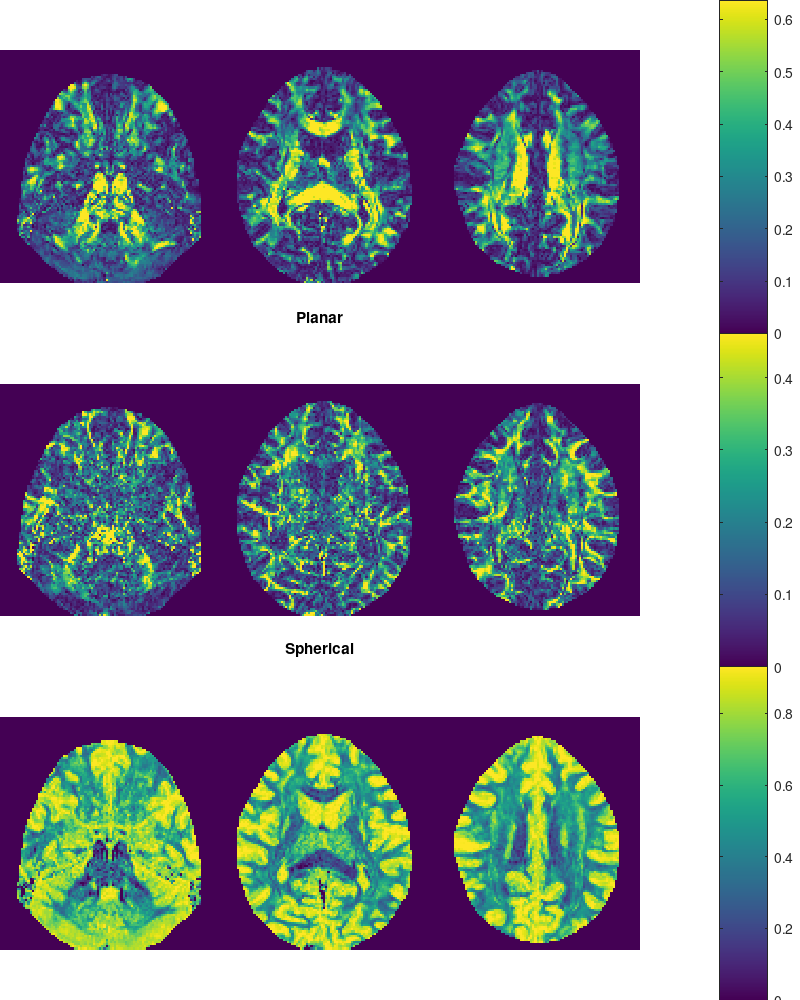

In [18]:
% The mean diffusivity, should be between 0.0 and free-water diffusivity,
% 3.0e-3 mm^2/s:
CL2 = spectrum2scalar( l1, l2, l3, 'mask', mask, 'scalar', 'clsq' );
% The fractional anisotropy, in the interval [0,1]:
CP2 = spectrum2scalar( l1, l2, l3, 'mask', mask, 'scalar', 'cpsq' );
% The realtive anisotropy, in the interval [0,1]:
CS2 = spectrum2scalar( l1, l2, l3, 'mask', mask, 'scalar', 'cssq' );
% -------------
FS = 24;
close(figure(3));
hf3 = figure(3);
set(hf3,'Name','Westin''s coefficients with RMS normalization','Position',[10,10,800,1000]);
% ---
R=3; C=1;
% ---
r=3; c=1; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
plotVolBW_demoDTI(CL2); title('Linear','FontSize',FS);
axis('equal');axis('off');axis('tight');
% ---
r=2; c=1; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
plotVolBW_demoDTI(CP2); title('Planar','FontSize',FS);
axis('equal');axis('off');axis('tight');
% ---
r=1; c=1; subplot('Position',[(c-1)/C,(r-1)/R,1/C,1/R]);
plotVolBW_demoDTI(CS2); title('Spherical','FontSize',FS);
axis('equal');axis('off');axis('tight');

## Represent color\-by orientation maps

A convenient way to represent both the anisotropy and the orientation information of the diffusion tensor is using color\-coded maps, which depend on the orientation of the main eigenvector, u1 (the one corresponding to the largest eigenvalue, l1): if u1 is oriented following the 'x' axis in one voxel, that voxel will be colored in red. If it is oriented along 'y', the color will be green. If it is oriented along 'z', the color will be blue.The brightness of the voxel is adjusted according to its FA. This way, both the dominant orientation of the bundles inside the voxel and the anisotropy can be checked with a glance. The function to call here is **spectrum2colorcode.m**:


In [19]:
colorcoded = spectrum2colorcode( u1, l1, l2, l3, 'mask', mask );
size(colorcoded), % The fourth dimension has the RGB channels
colorcoded = permute(colorcoded,[2,1,3,4]); % permute x-y axis



ans =

   101   110    17     3





Let's represent the central (axial) slice of the volume:


In [ ]:
IMG = squeeze(colorcoded(:,:,9,:));
close(figure(4));
hf4 = figure(4);
set(hf4,'Name','Color-coding for DT-MRI data','Position',[10,10,1000,1200]);
imshow(IMG);

## Represent glyphs

A more sophisticated way to represent DT\-MRI fields (and diffusion data, in general) is through glyphs. In the DT\-MRI case, they are usually ellipsoids at each voxel, whose main axis are aligned with the three orthonormal eigenvectors u1, u2, and u3 and whose semi\-axes are scaled according to the respective eigenvalues l1, l2, and l3. The function used to represent complex DT\-MRI data is **plotdmri3d.m**. Given its high complexity and the enormous number of options, let's place here a "just work's" example, and let the reader check its help for further details:


In [ ]:
% The function asks for a SH volume, so let's transform the tensor to a SH
% expansion up to order L=2:
SH = hot2sh(tensor,'mask',mask);
close(figure(5));
hf5 = figure(5);
ha = axes('Parent',hf5);
set(hf5,'Name','Glyphs for DT-MRI data','Position',[10,10,1000,1200]);
% Select a slice and fix the ijk -> xyz matrix:
i1 = [1,size(tensor,1)];
i2 = [1,size(tensor,2)];
i3 = [9,9];
direction = [1,0,0;0,-1,0;0,0,1];
% Plot an axial slice without glyphs, just the FA
[ha,ho] = plotdmri3d( SH, i1, i2, i3, 'ha', ha, ...
    'direction', direction, ...
    'bgimage', 'fa', 'bgsh', SH, ...
    'bgalpha', 1, 'mask', mask, 'bbox', true, 'glyphs', false );
% Remove the bounding boxes, keep the text:
delete(ho.bbox(1));
delete(ho.bbox(2));
% Add the glyphs in an overlay:
i1 = [25,83];
i2 = [27,41];
i3 = [9,9];
[ha,ho] = plotdmri3d( SH, i1, i2, i3, 'ha', ha, ...
    'direction', direction, ...
    'mframe', direction, ...
    'bgimage', 'fa', 'bgsh', SH, ...
    'bgalpha', 0, 'mask', mask, 'bbox', false, 'glyphs', true, ...
    'angleres', 642, 'glyphspc', [2;2;2], 'glyphsc', 2.0, ...
    'glyphscvar', 'bg' );
light;
axis('equal');
rotate3d('on');